# Tarea 4: Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: José Manuel Rubio Cienfuegos
Fecha de entrega: 11 de diciembre de 2020

In [ ]:
import os
import sys
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

from utils import ImageCaptionDataset, train_for_classification, train_for_retrieval

--2020-12-14 00:29:30--  https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7403 (7.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.23K  --.-KB/s    in 0s      

2020-12-14 00:29:30 (104 MB/s) - ‘utils.py’ saved [7403/7403]



In [ ]:
from torchsummary import summary
import torch.nn.functional as nnf

In [ ]:
# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# En caso que se les indique, cambia el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# En caso que se les indique, cambia el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-lmwn365r/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-lmwn365r/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5800 sha256=f4be403fc6fca8de741c4a846836029ba28ea008baa2f7d8ec1788e23d8b411c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8f50e5m3/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
Connection stablished


In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura Convolucional GoogLeNet (y otras) para CIFAR10

## 1a) Inception Module

In [ ]:
class InceptionModule(nn.Module):
  def __init__(self, 
               in_channels, 
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(InceptionModule, self).__init__()
    # Acá inicializa todos los parámetros
    self.in_channels = in_channels
    self.ch_3x3_reduce = nn.Conv2d(in_channels, ch_3x3_reduce, (1, 1), stride=1, padding=0)
    self.ch_5x5_reduce = nn.Conv2d(in_channels, ch_5x5_reduce, (1, 1), stride=1, padding=0)
    self.ch_3x3 = nn.Conv2d(ch_3x3_reduce, ch_3x3, (3, 3), stride=1, padding=1)
    self.ch_5x5 = nn.Conv2d(ch_5x5_reduce, ch_5x5, (5, 5), stride=1, padding=2)
    self.ch_pool_proj = nn.MaxPool2d((3, 3), stride=1, padding=1)
    self.ch_pool_1x1 = nn.Conv2d(in_channels, ch_pool_proj, (1, 1), stride=1, padding=0)
    self.ch_1x1 = nn.Conv2d(in_channels, ch_1x1, (1, 1), stride=1, padding=0)

  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    x_1 = self.ch_3x3_reduce(x)
    x_2 = self.ch_5x5_reduce(x)
    x_3 = self.ch_pool_proj(x)
    pool_x = self.ch_pool_1x1(x_3)
    x_1_out = self.ch_3x3(x_1)
    x_2_out = self.ch_5x5(x_2)
    x_4_out = self.ch_1x1(x)
    x_out = torch.cat([x_1_out, x_2_out, pool_x, x_4_out], dim=1)

    return x_out

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = InceptionModule(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
corrector.submit(homework=4, question="1a", test=1, token=token, answer=list(result.size()), time=t)

Correct Test!


## 1b) GoogLeNet

In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(GoogLeNet, self).__init__()

    # Define las capas de convolución y pooling de GoogLeNet
    # self.in_linear = nn.Linear(32*32,28*28)
    # self.flatten_in = nn.Flatten(2, 3)
    self.input_conv = nn.Conv2d(3, 64, (7, 7), stride=1, padding=3)
    self.max_pooling_in = nn.MaxPool2d((3, 3), stride=1, padding=1)
    self.input_conv2 = nn.Conv2d(64, 192, (3, 3), stride=1, padding=1)
    self.max_pooling_2 = nn.MaxPool2d((3, 3), stride=2, padding=1)
    self.localRespNorm = nn.LocalResponseNorm(size=2)
    self.inception_3a = InceptionModule(in_channels=192)
    self.inception_3b = InceptionModule(in_channels=256, ch_3x3_reduce=128, ch_5x5_reduce=32, ch_3x3=192, ch_5x5=96, ch_pool_proj=64, ch_1x1=128)
    self.inception_4a = InceptionModule(in_channels=480, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=208, ch_5x5=48, ch_pool_proj=64, ch_1x1=192)
    self.inception_4b = InceptionModule(in_channels=512, ch_3x3_reduce=112, ch_5x5_reduce=24, ch_3x3=224, ch_5x5=64, ch_pool_proj=64, ch_1x1=160)
    self.inception_4c = InceptionModule(in_channels=512, ch_3x3_reduce=128, ch_5x5_reduce=24, ch_3x3=256, ch_5x5=64, ch_pool_proj=64, ch_1x1=128)
    self.inception_4d = InceptionModule(in_channels=512, ch_3x3_reduce=144, ch_5x5_reduce=32, ch_3x3=288, ch_5x5=64, ch_pool_proj=64, ch_1x1=112)
    self.inception_4e = InceptionModule(in_channels=528, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)
    self.inception_5a = InceptionModule(in_channels=832, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)
    self.inception_5b = InceptionModule(in_channels=832, ch_3x3_reduce=192, ch_5x5_reduce=48, ch_3x3=384, ch_5x5=128, ch_pool_proj=128, ch_1x1=384)
    self.avg_pool = nn.AvgPool2d((7, 7), stride=1)
    self.Dropout = nn.Dropout(p=.4)
    self.flatten = nn.Flatten(1, 3)

    # Decide si usar la clasificación auxiliar
    self.use_aux_logits = use_aux_logits
    if self.use_aux_logits:
      # Acá lo que necesites inicializar en este caso
      self.Avg_middle = nn.AvgPool2d((5, 5), stride=3)
      self.Conv_4b = nn.Conv2d(512, 128, (1, 1), stride=1, padding=0)
      self.Conv_4e = nn.Conv2d(528, 128, (1, 1), stride=1, padding=0)
      self.Drop_middle = nn.Dropout(p=.7)
      # self.FC_middle = nn.Linear(2048, 1024)
      self.FC_middle_out = nn.Linear(2048, n_classes)

    self.hidden_fc = nn.Linear(1024, n_classes)
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(1024, n_classes)

  def forward(self, x):
    # Input
    x = nnf.interpolate(x, size=(28, 28), mode='bicubic', align_corners=False)
    # x_flat = self.flatten_in(x)
    # x_lin = self.in_linear(x_flat)
    # x = torch.reshape(x_lin, (x.size()[0], x.size()[1], 28, 28))
    x = F.relu(self.input_conv(x))
    x = F.relu(self.max_pooling_in(x))
    x = F.relu(self.localRespNorm(x))
    x = F.relu(self.input_conv2(x))
    x = F.relu(self.localRespNorm(x))
    x = F.relu(self.max_pooling_in(x))

    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None

    # Computa las representaciones internas de la red
    x_inc = F.relu(self.inception_3a(x))
    x_inc = F.relu(self.inception_3b(x_inc))
    x_inc = F.relu(self.max_pooling_2(x_inc))
    x_inc = F.relu(self.inception_4a(x_inc))
    x_inc_2 = F.relu(self.inception_4b(x_inc))

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits and self.training:
      x_aux_1 = F.relu(self.Avg_middle(x_inc))
      # print(x_aux_1.size())
      x_aux_1 = F.relu(self.Conv_4b(x_aux_1))
      x_aux_1 = F.relu(self.Drop_middle(x_aux_1))
      x_aux_1 = F.relu(self.flatten(x_aux_1))
      # x_aux_1 = F.relu(self.FC_middle(x_aux_1))
      # x_aux_1 = self.FC_middle_out(x_aux_1)
      aux_logit_1 = self.FC_middle_out(x_aux_1)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_1)

    # Continúa computando las representaciones internas de la red
    x_inc_2 = F.relu(self.inception_4c(x_inc_2))
    x_inc_2 = F.relu(self.inception_4d(x_inc_2))
    x_inc_3 = F.relu(self.inception_4e(x_inc_2))

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    aux_logit_2 = None
    if self.use_aux_logits and self.training:
      x_aux_2 = F.relu(self.Avg_middle(x_inc_2))
      x_aux_2 = F.relu(self.Conv_4e(x_aux_2))
      x_aux_2 = F.relu(self.Drop_middle(x_aux_2))
      x_aux_2 = F.relu(self.flatten(x_aux_2))
      # x_aux_2 = F.relu(self.FC_middle(x_aux_2))
      aux_logit_2 = self.FC_middle_out(x_aux_2)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_2)

    # Continúa computando las representaciones internas de la red
    
    x_inc_3 = F.relu(self.max_pooling_2(x_inc_3))
    x_inc_3 = F.relu(self.inception_5a(x_inc_3))
    x_inc_3 = F.relu(self.inception_5b(x_inc_3))
    x_av = F.relu(self.avg_pool(x_inc_3))
    x_hidden = F.relu(self.flatten(x_av))
    # print(x_hidden.size())
    x_hidden = self.hidden_fc(x_hidden)
    x_out = F.relu(self.Dropout(x_av))
    x_out = F.relu(self.flatten(x_out))

    # N x out_size
    logits = self.fc_out(x_out)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': x_hidden, 'logits': logits, 'aux_logits': aux_logits}

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, n_classes, use_aux_logits = corrector.get_test_data(homework=4, question="1b", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = GoogLeNet(n_classes=n_classes, use_aux_logits=use_aux_logits)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
sizes = [result['hidden'].shape[0]] + list(result['logits'].size()) + [d for a in result['aux_logits'] for d in a.size()]
corrector.submit(homework=4, question="1b", test=1, token=token, answer=sizes, time=t)

Correct Test!


## 1c) Arquitectura Convolucional: DenseNet



In [ ]:
# Módulo auxiliar para la implementación de la red DenseNet, DenseBlock inicial

class DenseBlock_in(nn.Module):
  def __init__(self, in_channels, L, k):
    super(DenseBlock_in, self).__init__()
    # self.device = device
    self.Convs_11 = dict()
    self.Convs_33 = dict()
    for l in range(L):
      if l == 0:
        self.Conv_11_in = nn.Conv2d(in_channels, k, (1, 1), stride=1, padding=0).to('cuda')
        self.Conv_33_in = nn.Conv2d(3*k, k, (3, 3), stride=1, padding=1).to('cuda')
      else:
        self.Convs_11[l] = nn.Conv2d(k, k, (1, 1), stride=1, padding=0).to('cuda')
        self.Convs_33[l] = nn.Conv2d((l+3)*k, k, (3, 3), stride=1, padding=1).to('cuda')
    # self.Conv_11 = nn.Conv2d(k, k, (1, 1), stride=1, padding=0)
    # self.Conv_33 = nn.Conv2d(4*k, k, (3, 3), stride=1, padding=1)
    self.L = L

    # Batch Normalization
    self.BN_in = nn.BatchNorm2d(32)
    self.BN = nn.BatchNorm2d(32)

  # Pasada hacia delante

  def forward(self, x):
    x_out = x               # Inicializando la salida del DenseBlock
    x_acumulated = [x_out]
    for l in range(self.L):
      if l == 0:
        x_out = self.BN_in(F.relu(self.Conv_11_in(x_out)))
        x_acumulated.append(x_out)
        x_out = torch.cat(x_acumulated, dim=1)
        x_out = self.BN(F.relu(self.Conv_33_in(x_out)))
      else:
        x_out = self.BN(F.relu(self.Convs_11[l](x_out)))
        x_acumulated.append(x_out)
        x_out = torch.cat(x_acumulated, dim=1)
        x_out = self.BN(F.relu(self.Convs_33[l](x_out)))
    return x_out

In [ ]:
# Módulo auxiliar para la implementación de la red DenseNet, DenseBlock

class DenseBlock(nn.Module):
  def __init__(self, in_channels, L, k):
    super(DenseBlock, self).__init__()
    # self.device = device
    self.Convs_11 = dict()
    self.Convs_33 = dict()
    for l in range(L):
      if l == 0:
        self.Conv_11_in = nn.Conv2d(in_channels, k, (1, 1), stride=1, padding=0).to('cuda')
        self.Conv_33_in = nn.Conv2d(2*k, k, (3, 3), stride=1, padding=1).to('cuda')
      else:
        self.Convs_11[l] = nn.Conv2d(k, k, (1, 1), stride=1, padding=0).to('cuda')
        self.Convs_33[l] = nn.Conv2d((l+2)*k, k, (3, 3), stride=1, padding=1).to('cuda')
    # self.Conv_11 = nn.Conv2d(k, k, (1, 1), stride=1, padding=0)
    # self.Conv_33 = nn.Conv2d(4*k, k, (3, 3), stride=1, padding=1)
    self.L = L

    # Batch Normalization
    self.BN_in = nn.BatchNorm2d(32)
    self.BN = nn.BatchNorm2d(32)

  # Pasada hacia delante

  def forward(self, x):
    x_out = x               # Inicializando la salida del DenseBlock
    x_acumulated = [x_out]
    for l in range(self.L):
      if l == 0:
        x_out = self.BN_in(F.relu(self.Conv_11_in(x_out)))
        x_acumulated.append(x_out)
        x_out = torch.cat(x_acumulated, dim=1)
        x_out = self.BN(F.relu(self.Conv_33_in(x_out)))
      else:
        x_out = self.BN(F.relu(self.Convs_11[l](x_out)))
        x_acumulated.append(x_out)
        x_out = torch.cat(x_acumulated, dim=1)
        x_out = self.BN(F.relu(self.Convs_33[l](x_out)))
    return x_out

In [ ]:
# Acá el código para tu primera arquitectura

class DenseNet(nn.Module):
  def __init__(self, n_classes):
    super(DenseNet, self).__init__()

    self.in_linear = nn.Linear(32*32,224*224)
    self.flatten_in = nn.Flatten(2, 3)

    # Define las capas de convolución y pooling de tu arquitectura
    self.Conv_in = nn.Conv2d(3, 64, (7, 7), stride=2, padding=3)
    self.Pooling = nn.MaxPool2d((3, 3), stride=2, padding=1)
    self.DenseB_1 = DenseBlock_in(64, 6, 32)
    self.Conv_trans = nn.Conv2d(32, 32, (1, 1), stride=1, padding=0)
    self.AV_trans = nn.AvgPool2d((2, 2), stride=2, padding=0)
    self.DenseB_2 = DenseBlock(32, 12, 32)
    self.DenseB_3 = DenseBlock(32, 24, 32)
    self.DenseB_4 = DenseBlock(32, 16, 32)
    self.AV_out = nn.AvgPool2d((7, 7), stride=1)
    self.flatten = nn.Flatten(1, 3)

    self.fc_hidden3 = nn.Linear(14*14*32, n_classes)

    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(32, n_classes)

  def forward(self, x):
    # Llevando las imágenes a una escala de 224x224

    x = nnf.interpolate(x, size=(224, 224), mode='bicubic', align_corners=False)

    # Computa las representaciones internas de la red
    
    x = F.relu(self.Conv_in(x))
    x = self.Pooling(x)
    x = F.relu(self.DenseB_1(x))
    x = F.relu(self.Conv_trans(x))
    x = self.AV_trans(x)
    x = self.DenseB_2(x)
    x = self.Conv_trans(x)
    x = self.AV_trans(x)
    x = self.DenseB_3(x)

    # Tensor de la capa oculta

    x_hidden = self.flatten(x)
    hidden = self.fc_hidden3(x_hidden)

    # Continuando computando las representaciones de la red

    x = self.Conv_trans(x)
    x = self.AV_trans(x)
    x = self.DenseB_4(x)
    x_out = self.AV_out(x)
    x_out = self.flatten(x_out) 

    # N x out_size
    logits = self.fc_out(x_out)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits}

## Arquitectura Personalizada (CNN)

In [ ]:
class Personal_CNN(nn.Module):
  def __init__(self, nclasses):
    super(Personal_CNN, self).__init__()

    # Inicializadores de las capas necesarias para la arquitectura grande.

    self.nclasses = nclasses
    self.conv1 = nn.Conv2d(3, 64, (3, 3), stride=1, padding=1)
    self.conv2 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 128, (3, 3), stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, (3, 3), stride=1, padding=1)
    self.conv6 = nn.Conv2d(256, 256, (3, 3), stride=1, padding=1)
    self.conv7 = nn.Conv2d(256, 512, (3, 3), stride=1, padding=1)
    self.conv8 = nn.Conv2d(512, 512, (3, 3), stride=1, padding=1)
    self.MaxPool = nn.MaxPool2d((3, 3), stride=2, padding=1)
    self.BN1 = nn.BatchNorm2d(64)
    self.BN2 = nn.BatchNorm2d(128)
    self.BN3 = nn.BatchNorm2d(256)
    self.BN4 = nn.BatchNorm2d(512)
    self.BN1d1 = nn.BatchNorm1d(128)
    self.BN1d2 = nn.BatchNorm1d(256)
    self.BN1d3 = nn.BatchNorm1d(512)
    self.BN1d4 = nn.BatchNorm1d(1024)
    self.flatten = nn.Flatten(1, 3)
    self.fc_1 = nn.Linear(2048, 128)
    self.fc_hidden = nn.Linear(128, nclasses)
    self.fc_2 = nn.Linear(128, 256)
    self.fc_3 = nn.Linear(256, 512)
    self.fc_4 = nn.Linear(512, 1024)
    self.fc_out = nn.Linear(1024, nclasses)

  # Pasada hacia adelante.

  def forward(self, x):
    x = self.BN1(F.relu(self.conv1(x)))
    x = self.BN1(F.relu(self.conv2(x)))
    x = self.MaxPool(x)
    x = self.BN2(F.relu(self.conv3(x)))
    x = self.BN2(F.relu(self.conv4(x)))
    x = self.MaxPool(x)
    x = self.BN3(F.relu(self.conv5(x)))
    x = self.BN3(F.relu(self.conv6(x)))
    x = self.MaxPool(x)
    x = self.BN4(F.relu(self.conv7(x)))
    x = self.BN4(F.relu(self.conv8(x)))
    x = self.MaxPool(x)
    x = self.flatten(x)
    # print(x.size())
    x = self.BN1d1(F.relu(self.fc_1(x)))
    hidden = self.fc_hidden(x)
    x = self.BN1d2(F.relu(self.fc_2(x)))
    x = self.BN1d3(F.relu(self.fc_3(x)))
    x = self.BN1d4(F.relu(self.fc_4(x)))
    logits = self.fc_out(x)
    return {'hidden': hidden, 'logits': logits}

In [ ]:
device = 'cuda'
test_model = Personal_CNN(10).to(device)
summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]         590,080
      BatchNorm2d-14            [-1, 25

In [ ]:
device = 'cuda'
test_model = DenseNet(n_classes=10).to(device)
summary(test_model, input_size=(3, 32, 32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 32, 56, 56]           2,080
       BatchNorm2d-4           [-1, 32, 56, 56]              64
            Conv2d-5           [-1, 32, 56, 56]          27,680
       BatchNorm2d-6           [-1, 32, 56, 56]              64
       BatchNorm2d-7           [-1, 32, 56, 56]              64
       BatchNorm2d-8           [-1, 32, 56, 56]              64
       BatchNorm2d-9           [-1, 32, 56, 56]              64
      BatchNorm2d-10           [-1, 32, 56, 56]              64
      BatchNorm2d-11           [-1, 32, 56, 56]              64
      BatchNorm2d-12           [-1, 32, 56, 56]              64
      BatchNorm2d-13           [-1, 32, 56, 56]              64
      BatchNorm2d-14           [-1, 32,

In [ ]:
device = 'cuda'
test_model = GoogLeNet(n_classes=10, use_aux_logits=True).to(device)
summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           9,472
         MaxPool2d-2           [-1, 64, 28, 28]               0
 LocalResponseNorm-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 192, 28, 28]         110,784
 LocalResponseNorm-5          [-1, 192, 28, 28]               0
         MaxPool2d-6          [-1, 192, 28, 28]               0
            Conv2d-7           [-1, 96, 28, 28]          18,528
            Conv2d-8           [-1, 16, 28, 28]           3,088
         MaxPool2d-9          [-1, 192, 28, 28]               0
           Conv2d-10           [-1, 32, 28, 28]           6,176
           Conv2d-11          [-1, 128, 28, 28]         110,720
           Conv2d-12           [-1, 32, 28, 28]          12,832
           Conv2d-13           [-1, 64, 28, 28]          12,352
  InceptionModule-14          [-1, 256,

## 1d) Clasificación de Imágenes en CIFAR10

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos 
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 10
REPORTS_EVERY = 1

net = Personal_CNN(10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.Adam(net.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2)  # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=4)

# train_loss, acc = train_for_classification(net, train_loader, 
#                                            test_loader, optimizer, 
#                                            criterion, lr_scheduler=None, 
#                                            epochs=EPOCHS, reports_every=REPORTS_EVERY)

# plot_results(train_loss, acc)

In [ ]:
train_acc, test_acc, train_loss = [], [], []
epochs = 10

total_train = 50000
total_test = 10000

net.cuda()

for epoch in range(epochs):

  # El entrenamiento de los parametros se realizaran mediante .train()
  net.train()

  # Inicializando el valor para las métricas.
  running_loss, running_acc = 0.0, 0.0

  for i, data in enumerate(train_loader, 0):
    labels = data[1].cuda()
    inputs = data[0].float().cuda()
    optimizer.zero_grad()
    outputs = net(inputs)['logits']
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    items = (i+1) * BATCH_SIZE
    running_loss += loss.item()

    Y_pred = F.softmax(outputs, dim=1)
    max_prob, max_idx = torch.max(Y_pred, dim=1)
    running_acc += torch.sum(max_idx == labels).item()
    info = f'\rEpoch:{epoch+1}({items}/{total_train}), '
    info += f'Loss:{running_loss/(i+1):02.5f}, '
    info += f'Train Acc:{running_acc/items*100:02.1f}%'
    sys.stdout.write(info)

  train_acc.append(running_acc)
  train_loss.append(running_loss)

  # net.eval()
  with torch.no_grad():
    running_acc = 0.0
    for i, data in enumerate(test_loader, 0):
      labels = data[1].cuda()
      inputs = data[0].float().cuda()
      Y_pred = net(inputs)['logits']
      Y_pred = F.softmax(Y_pred, dim=1)
      max_prob, max_idx = torch.max(Y_pred, dim=1)
      running_acc += torch.sum(max_idx == labels).item()
    info = f', Val Acc:{running_acc/total_test*100:02.2f}%.\n'
    sys.stdout.write(info)

  test_acc.append(running_acc)

Epoch:1(50016/50000), Loss:1.53112, Train Acc:44.8%, Val Acc:57.50%.
Epoch:2(50016/50000), Loss:1.00877, Train Acc:65.1%, Val Acc:68.11%.
Epoch:3(50016/50000), Loss:0.77930, Train Acc:73.9%, Val Acc:73.96%.
Epoch:4(50016/50000), Loss:0.62938, Train Acc:78.8%, Val Acc:78.62%.
Epoch:5(50016/50000), Loss:0.52257, Train Acc:82.7%, Val Acc:79.02%.
Epoch:6(50016/50000), Loss:0.42706, Train Acc:85.8%, Val Acc:81.79%.
Epoch:7(50016/50000), Loss:0.34857, Train Acc:88.3%, Val Acc:83.37%.
Epoch:8(50016/50000), Loss:0.29136, Train Acc:90.4%, Val Acc:83.53%.
Epoch:9(50016/50000), Loss:0.22458, Train Acc:92.5%, Val Acc:83.37%.
Epoch:10(50016/50000), Loss:0.17751, Train Acc:93.9%, Val Acc:84.11%.


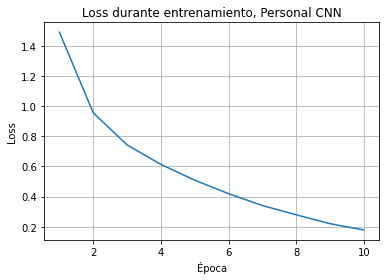

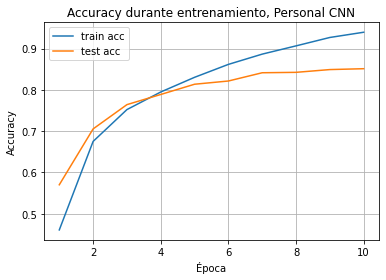

In [ ]:
Epochs = range(1, EPOCHS+1)

plt.plot(Epochs, np.array(train_loss)/1570, label='train loss')
plt.title('Loss durante entrenamiento, Personal CNN')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.plot(Epochs, np.array(train_acc)/50000, label='train acc')
plt.plot(Epochs, np.array(test_acc)/10000, label='test acc')
plt.title('Accuracy durante entrenamiento, Personal CNN')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Epoch:1(50000/50000), Loss:1.80128, Train Acc:29.2%, Validating..., Val Acc:41.13%, Avg-Time:147.924s.
Epoch:2(50000/50000), Loss:1.44106, Train Acc:46.4%, Validating..., Val Acc:52.30%, Avg-Time:147.480s.
Epoch:3(50000/50000), Loss:1.26406, Train Acc:54.5%, Validating..., Val Acc:58.91%, Avg-Time:147.233s.
Epoch:4(50000/50000), Loss:1.14878, Train Acc:59.3%, Validating..., Val Acc:61.33%, Avg-Time:147.031s.
Epoch:5(50000/50000), Loss:1.04747, Train Acc:63.7%, Validating..., Val Acc:60.94%, Avg-Time:146.911s.
Epoch:6(50000/50000), Loss:0.96966, Train Acc:66.5%, Validating..., Val Acc:66.18%, Avg-Time:146.828s.
Epoch:7(50000/50000), Loss:0.90393, Train Acc:69.1%, Validating..., Val Acc:68.86%, Avg-Time:146.769s.
Epoch:8(50000/50000), Loss:0.84175, Train Acc:71.8%, Validating..., Val Acc:70.72%, Avg-Time:146.697s.
Epoch:9(50000/50000), Loss:0.79032, Train Acc:73.3%, Validating..., Val Acc:71.10%, Avg-Time:146.647s.
Epoch:10(50000/50000), Loss:0.74107, Train Acc:75.5%, Validating..., Val 

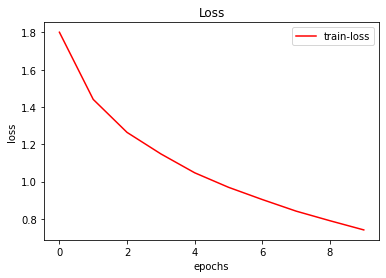

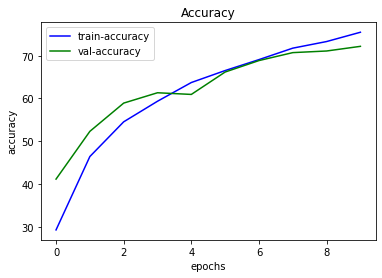

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 10
REPORTS_EVERY = 1

Gnet = GoogLeNet(10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.Adam(Gnet.parameters()) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2)  # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=4)

train_loss, acc = train_for_classification(Gnet, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=None, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

In [ ]:
# Test
x, y = list(test_loader)[0]
net.cpu()
# net.eval()
with torch.no_grad():
  y_pred = net(x)['logits'].max(dim=1)[1]

  # Veamos como se comporta el modelo
  print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Correct Test!


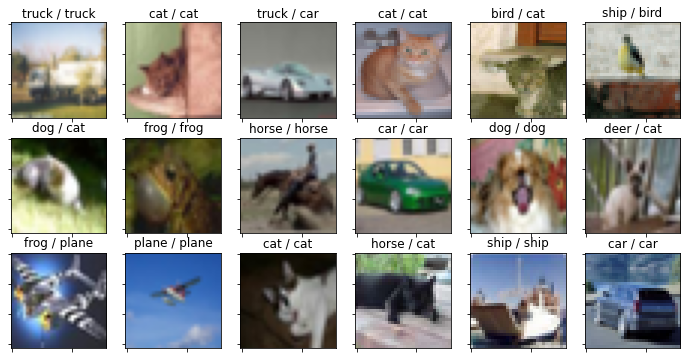

In [ ]:
from random import randint

Gnet = Gnet.to('cpu').eval()

w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
for i in range(h):
  for j in range(w):
    idx = randint(0,total_test)
    T, real = testset[idx]
    
    # Convertimos la imagen en un batch
    X = T.view(1,3,32,32)
    Y = F.softmax(Gnet(X)['logits'], dim=1)
    prob, pred = torch.max(Y, dim=1)
    prob = prob.item()
    pred = pred.item()
    
    T = T / 2 + 0.5
    T = T.permute(1,2,0) 
    
    img = T.numpy()
    title = classes[pred] + ' / ' + classes[real] 
    axs[i,j].set_title(title)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)


## 1e) Opcional: CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = ...
LR = ...
EPOCHS = ...
REPORTS_EVERY = 1

net = ... # tu modelo de CNN (para clasificar en 100 clases)
optimizer = ... # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

# Parte 2: Subtitulado de Imágenes mediante Recuperación de Textos

## 2a) Codificación de Imágenes y Textos

In [ ]:
class ImageEncoding(nn.Module):
  def __init__(self, cnn_model, cnn_out_size, out_size=128):
    super(ImageEncoding, self).__init__()
    self.cnn_model = cnn_model
    self.cnn_out_size = cnn_out_size
    self.out_size = out_size
    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    ...
    self.Linear_1 = nn.Linear(10, cnn_out_size)
    self.Dropout = nn.Dropout(p=.5)
    self.Linear_2 = nn.Linear(cnn_out_size, out_size)

  def forward(self, x):
    x = self.cnn_model(x)['hidden']
    # print(x.size())
    # Compute las capas de su MLP
    
    x = self.Linear_1(x)
    x = self.Dropout(x)
    x_out = self.Linear_2(x)
    # En fc_out debe almacenar el encoding en R^d
    return {'logits': x_out}

In [ ]:
class TextEncoding(nn.Module):
  def __init__(self, text_embedding_size=4096, out_size=128):
    super(TextEncoding, self).__init__()

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.text_embedding_size = text_embedding_size
    self.out_size = out_size

    self.Linear_1 = nn.Linear(text_embedding_size, 1024)
    self.Dropout = nn.Dropout(p=.5)
    self.Linear_out = nn.Linear(1024, out_size)

    # self.use_last_bn = use_last_bn
    # if use_last_bn:
    #   self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    # Compute las capas de su MLP
    x = self.Linear_1(x)
    x = self.Dropout(x)
    x_out = self.Linear_out(x)
    # x_out = self.bn(x_out)

    # En logits debe almacenar el encoding en R^d
    return {'logits': x_out}

In [ ]:
# Test
OUT_SIZE = 200

cnn_net = GoogLeNet(n_classes=10)
i_enc = ImageEncoding(cnn_model=cnn_net, cnn_out_size=1024, out_size=OUT_SIZE)
t_enc = TextEncoding(text_embedding_size=4096, out_size=OUT_SIZE)
i_enc.eval()
t_enc.eval()

# Veamos como se comportan tus encoders
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size()==t_enc(torch.randn(9,4096))['logits'].size()) else "Failed Test [size]")
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size(-1)==OUT_SIZE) else "Failed Test [size]")

Correct Test!
Correct Test!


## 2b) Buenas codificaciones y la *Triplet Loss*

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=.2, negative='max'):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.negative = negative
    # self.Image_Encoding = ImageEncoding(GoogLeNet, 1024)
    # self.Text_Encoding = TextEncoding(text_embedding_size=12)

  def forward(self, anchor, positive):

    # Posiblemente lo más simple es partir calculando la distancia Euclideana
    # entre las imagenes ancla y todos los pares (B x B) de representaciones
    # de textos (hint: usa torch.cdist)
    dists = torch.cdist(anchor, positive)
    # print('dists: ', dists)
    # Obtener distancias "positivas" de la diagonal
    p_dists = dists.diagonal()
    P_dist = torch.reshape(p_dists, (len(p_dists), 1))
    # print('diagonal: ', p_dists)
    p_size = p_dists.size()[0]

    Cost = P_dist - dists + self.margin
    # print('Cost: ', Cost)

    # Ahora genera un tensor con todos los costos que se deben agregar
    # dependiendo de la forma de encontrar los negativos
    if self.negative == 'max':
      cost = torch.max(Cost, dim=1)[0]
      # print('max_for_row: ', cost)
      cost = torch.reshape(cost, (len(cost), 1))

    elif self.negative == 'random':
      tensor_rand = torch.randint(0, p_size, (p_size,), dtype=torch.int16)    # Creando una lista de numeros aleatorios
      t_range = torch.range(0, p_size-1, dtype=torch.int16)                   # Tensor con los números continuos
      t_moved = t_range - 1
      torch_rand = torch.where(tensor_rand - t_range == 0, t_moved, tensor_rand) # En caso de que se tenga número que coinciden con su posición, entonces se les quita 1.
      cost_list = []
      for p in range(p_size):
        cost_list.append(dists[p, torch_rand[p]])
      cost = torch.tensor(cost_list, dtype=torch.float32)
    elif self.negative == 'all':
      cost = torch.zeros(p_size, p_size - 1)
      for p in range(p_size):
        cost[p] = torch.cat([dists[p][:p], dists[p][p+1:]])
    else:
      raise ValueError()
    # print('cost: ', cost)
    # print(cost.size())
    Cost = (P_dist - cost + self.margin).cuda()
    # print('Cost: ', Cost)
    zeros = torch.zeros(Cost.size()).cuda()
    # print(Cost.size())
    loss = torch.where(Cost > zeros, Cost, zeros)
    # print(loss.mean())
    # print(loss.mean())
    # Retorna el promedio de los costos de todos los triples considerados
    return loss.mean()

In [ ]:
# Tests del API del curso para TripletLoss

# Obtengamos algunos parametros para probar tu implementación
for test in [1,2]:
  a, p, m, n  = corrector.get_test_data(homework=4, question="2b", test=test, token=token)

  criterion = TripletLoss(margin=m, negative=n)
  result = criterion(torch.tensor(a), torch.tensor(p)).item()

  # Veamos si todo fue OK :)
  corrector.submit(homework=4, question="2b", test=test, token=token, answer=result, time=0)

Using cached test data


FailedTest: ignored

## 2c) Probando tu implementación en Flickr8k

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
  print('\n*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
  print('****** Descargando las imágenes...\n')
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images
  print('\n********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset',
                                                ann_file = f'{folder_path}/annotations/8k-pictures.html',
                                                transform=transform)
print('Creando train, val y test splits...')

train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)


*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...
****** Descargando las imágenes...

--2020-12-14 01:49:40--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi  96%[==================> ]   1.01G  2.41MB/s    in 2m 18s  

2020-12-14 01:51:59 (7.44 MB/s) - Connection closed at byte 1080500245. Retrying.

--2020-12-14 01:52:00--  (try: 2)  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1115419746 (1.0G), 34919501 (33M) remaining [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flic

In [ ]:
##############################################################################
# Descarguemos representaciones de los textos de 4096 dimensiones
##############################################################################
if not os.path.exists(f'{folder_path}/flickr_cap_encodings_4096d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl -P $folder_path

with open(f'{folder_path}/flickr_cap_encodings_4096d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs, test_cap_encs = pickle.load(f)

# Creamos un dataset para cada uno de los splits con nuestro ImageCaptionDataset
train_flickr_tripletset = ImageCaptionDataset(train_flickr_set, train_cap_encs)
val_flickr_tripletset = ImageCaptionDataset(val_flickr_set, val_cap_encs)
test_flickr_tripletset = ImageCaptionDataset(test_flickr_set, test_cap_encs)

##############################################################################
# Acá termina el código para preparar los datos
##############################################################################

--2020-12-14 01:54:53--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628212160 (599M) [application/octet-stream]
Saving to: ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’

flickr_cap_encoding 100%[===================>] 599.11M  10.9MB/s    in 2m 6s   

2020-12-14 01:57:00 (4.74 MB/s) - ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’ saved [628212160/628212160]



Epoch:1(6000/6000), Loss:2.66270, Train MRR:0.08 R@10:15.45%, Validating...MRR:0.08 R@10:15.88% Avg-Time:4.569s.
Epoch:2(6000/6000), Loss:1.19309, Train MRR:0.08 R@10:15.13%, Validating...MRR:0.08 R@10:15.08% Avg-Time:4.548s.
Epoch:3(6000/6000), Loss:0.88455, Train MRR:0.08 R@10:15.56%, Validating...MRR:0.08 R@10:15.98% Avg-Time:4.550s.
Epoch:4(6000/6000), Loss:0.77085, Train MRR:0.07 R@10:15.34%, Validating...MRR:0.08 R@10:16.95% Avg-Time:4.544s.
Epoch:5(6000/6000), Loss:0.84512, Train MRR:0.08 R@10:16.20%, Validating...MRR:0.08 R@10:15.57% Avg-Time:4.538s.
Epoch:6(6000/6000), Loss:0.96044, Train MRR:0.07 R@10:16.08%, Validating...MRR:0.07 R@10:16.02% Avg-Time:4.539s.
Epoch:7(6000/6000), Loss:1.00544, Train MRR:0.07 R@10:15.99%, Validating...MRR:0.08 R@10:16.25% Avg-Time:4.539s.
Epoch:8(6000/6000), Loss:0.91034, Train MRR:0.07 R@10:15.91%, Validating...MRR:0.07 R@10:15.98% Avg-Time:4.538s.
Epoch:9(6000/6000), Loss:0.94694, Train MRR:0.08 R@10:15.79%, Validating...MRR:0.08 R@10:16.45% 

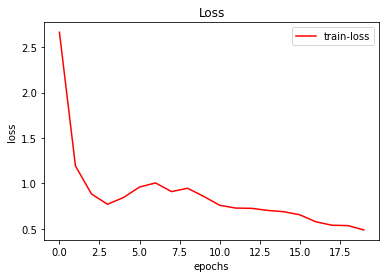

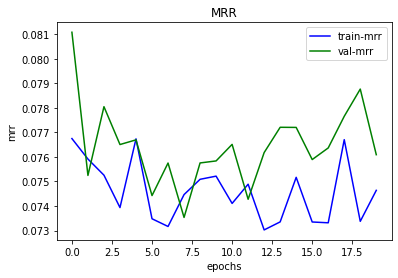

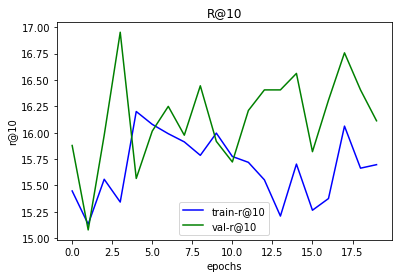

In [ ]:
##############################################################################
# Esta es la parte donde tienes que modificar para poder probar tu 
# implementación. 
# En general sólo es necesario que modifiques los lugares con "...", pero 
# eres libre de hacer tus propias implementaciones de todo lo que aparece.
##############################################################################

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 20
REPORTS_EVERY = 1
CNN_OUT_SIZE = 12
EMBEDDING_SIZE = 4096
OUT_SIZE = 512
MARGIN = .2
NEGATIVE = 'max'

cnn_net = Personal_CNN(10)
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_OUT_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': img_net.parameters()},  # lista de parametros de img_net
                        {'params': text_net.parameters()}],  # lista de parametros de text_net
                       lr=LR)
criterion = TripletLoss(margin=MARGIN, negative=NEGATIVE)
scheduler = None # (opcional) optim.lr_scheduler proporciona varios métodos 
                # para ajustar el lr según el número de épocas

train_triplets_loader = DataLoader(train_flickr_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_flickr_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                              train_triplets_loader, 
                                              val_triplets_loader, optimizer, 
                                              criterion, scheduler, EPOCHS, 
                                              REPORTS_EVERY, norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

Failed Test! [R@10]


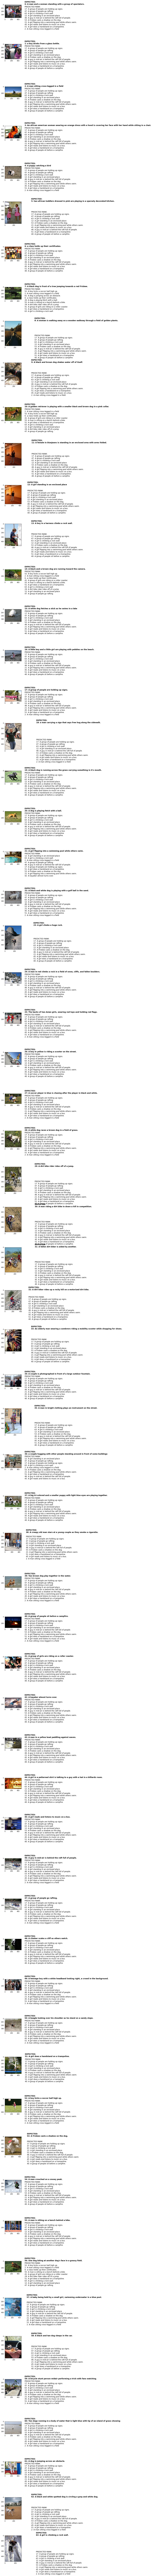

In [ ]:
# Test
from PIL import Image
n_samples = 64

# Tomemos n_samples ejemplos del conjunto de test
samples = torch.stack([test_flickr_tripletset[i][0] for i in range(n_samples)]).cuda()
refs = torch.stack([torch.from_numpy(test_flickr_tripletset[i][1]) for i in range(n_samples)]).cuda()
test_caps = [caps[0] for _, caps in test_flickr_set][:n_samples]

# Computamos las representaciones en el espacio compartido
samples_enc = img_net(samples)['logits']
refs_enc = text_net(refs)['logits']

# Calculemos las distancias a cada uno de los textos de test y rankeamos
dists = torch.cdist(samples_enc.unsqueeze(0), refs_enc.unsqueeze(0), p=2).squeeze(0)
ranks = torch.argsort(dists, dim=1)[:,:10]
r10 = len([i for i in range(len(ranks)) if len(torch.where(ranks[i,:] == i)[0])]) / len(ranks)

# Veamos como se comporta el modelo
print("Correct Test!" if r10 >= .25 else "Failed Test! [R@10]")

# Mostremos las 10 descripciones más cercanas
fig, axs = plt.subplots(nrows=n_samples, figsize=(2,n_samples*5))
for i in range(n_samples):
  axs[i].imshow(Image.open(full_flickr_set.ids[7000+i]))
  axs[i].text(600,0,"EXPECTED:\n{}: {}".format(i, test_caps[i]), fontsize=12, fontweight='bold')
  axs[i].text(600,750,"PREDICTED RANK:\n{}".format('\n'.join([f'{j}: {test_caps[j]}' for j in ranks[i]])), fontsize=12)

## 2d) Opcional: COCO Captions

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para COCO Captions.
##############################################################################

folder_path = './data/coco-caps'
if not os.path.exists(f'{folder_path}/images/train2014'):
  print('\n*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...')
  print('****** Descargando training set...\n')
  !wget http://images.cocodataset.org/zips/train2014.zip -P $folder_path/images
  print('\n********* Extrayendo training set...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/train2014.zip -d $folder_path/images && rm $folder_path/images/train2014.zip
  print('\n*** Descargando y extrayendo validation set...\n')
  !wget http://images.cocodataset.org/zips/val2014.zip -P $folder_path/images && unzip -q $folder_path/images/val2014.zip -d $folder_path/images && rm $folder_path/images/val2014.zip
  # !wget http://images.cocodataset.org/zips/test2014.zip -P $folder_path/images && unzip -q $folder_path/images/test2014.zip -d $folder_path/images && rm $folder_path/images/test2014.zip
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P $folder_path && unzip -q $folder_path/annotations_trainval2014.zip -d $folder_path && rm $folder_path/images/annotations_trainval2014.zip

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/train2014',
                                                   annFile = f'{folder_path}/annotations/captions_train2014.json',
                                                   transform=transform)

val_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/val2014',
                                                 annFile = f'{folder_path}/annotations/captions_val2014.json',
                                                 transform=transform)

# test_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/test2014',
#                                                   transform=transform)

In [ ]:
if not os.path.exists(f'{folder_path}/cap_encodings_512d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl -P $folder_path

with open(f'{folder_path}/cap_encodings_512d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs = pickle.load(f)

train_coco_tripletset = ImageCaptionDataset(train_coco_set, train_cap_encs)
val_coco_tripletset = ImageCaptionDataset(val_coco_set, val_cap_encs)

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_PREV_SIZE = 1024
EMBEDDING_SIZE = 512
OUT_SIZE = 512
MARGIN = .2

cnn_net = ...
img_net = ImageEncoding(cnn_model=..., cnn_out_size=CNN_PREV_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...},
                        {'params': ...}], 
                       lr=LR)
criterion = TripletLoss(margin=...)

train_triplets_loader = DataLoader(train_coco_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_coco_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                                     train_triplets_loader, 
                                                     val_triplets_loader, 
                                                     optimizer, criterion, 
                                                     EPOCHS, REPORTS_EVERY, 
                                                     norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')